In [1]:
# =====================================
# 1. Imports and Setup
# =====================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

# Verify CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


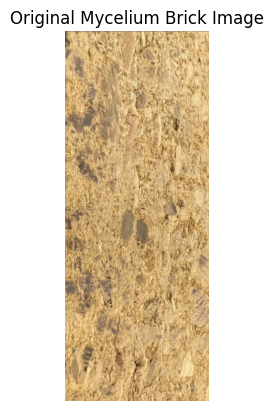

In [ ]:
# =====================================
# 2. Image Loading and Preprocessing
# =====================================

# Path to sample image
img_path = "SampleBrick.png"  
img = Image.open(img_path).convert("RGB")

# Defining the same normalization used by ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)  # shape (1,3,224,224)
input_tensor = input_tensor.to(device)

plt.imshow(np.array(img))
plt.title("Original Mycelium Brick Image")
plt.axis("off")
plt.show()


In [3]:
# =====================================
# 3. Load Pretrained ResNet50
# =====================================
model = models.resnet50(pretrained=True)

# Freeze early layers (transfer learning)
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer with regression head for orientation angle prediction
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # single output: angle (degrees or radians)
model = model.to(device)

print(model)


C:\Users\20vnk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20vnk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# =====================================
# 4. Feature Extraction
# =====================================
with torch.no_grad():
    features = model(input_tensor)

print("Output shape:", features.shape)
print("Predicted (dummy) orientation angle:", features.item())


Output shape: torch.Size([1, 1])
Predicted (dummy) orientation angle: -0.23487645387649536


Feature map shape: torch.Size([2048, 7, 7])


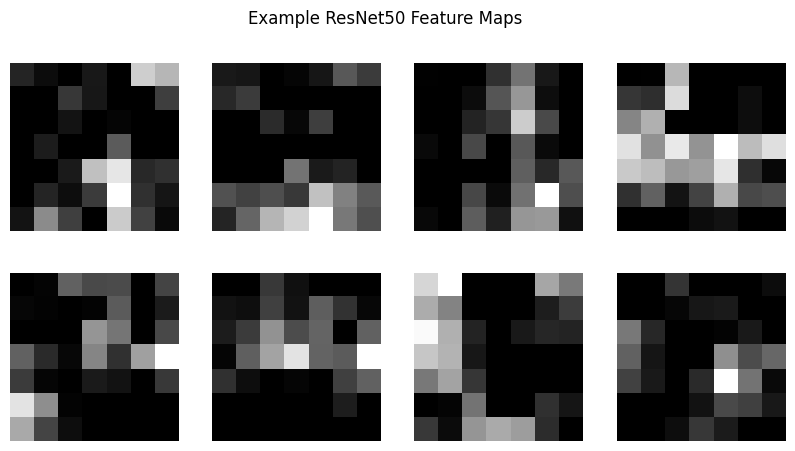

In [ ]:
# =====================================
# 5. Visualize Intermediate Feature Maps
# =====================================


# Remove last FC layers
feature_extractor = nn.Sequential(*list(model.children())[:-2])
feature_extractor = feature_extractor.to(device)

with torch.no_grad():
    fmap = feature_extractor(input_tensor).cpu().squeeze()

print("Feature map shape:", fmap.shape)  # [C,H,W]

# Visualize a few channels
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    axs[i//4, i%4].imshow(fmap[i].numpy(), cmap='gray')
    axs[i//4, i%4].axis('off')
plt.suptitle("Example ResNet50 Feature Maps")
plt.show()


In [ ]:
# =====================================
# 6. Dataset and DataLoader
# =====================================

class BrickDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(".png")]
        self.transform = transform
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        
        label = np.random.uniform(0, 180)  # dummy angle until annotated
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)


In [ ]:
# =====================================
# 7. Training Loop (Orientation Regression)
# =====================================

dataset = BrickDataset("Sample", transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(loader):.4f}")


Epoch [1/10] - Loss: 695.2947
Epoch [2/10] - Loss: 3.5547
Epoch [3/10] - Loss: 668.0957
Epoch [4/10] - Loss: 8942.5127
Epoch [5/10] - Loss: 1408.1217
Epoch [6/10] - Loss: 22351.0762
Epoch [7/10] - Loss: 20627.4746
Epoch [8/10] - Loss: 10227.1436
Epoch [9/10] - Loss: 25.3622
Epoch [10/10] - Loss: 19529.3594


In [23]:
from PIL import Image
import os

img_path = "Sample\SampleBrick.png"
img = Image.open(img_path).convert("RGB")

save_dir = "rotated_images"
os.makedirs(save_dir, exist_ok=True)

angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

for angle in angles:
    rotated = img.rotate(angle, expand=True)
    rotated.save(f"{save_dir}/brick_{angle}.png")
print(f"Generated {len(angles)} rotated images.")


Generated 12 rotated images.


In [24]:
class BrickRotationDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        file_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        
        # Extract angle from filename
        angle = float(file_name.split("_")[1].split(".")[0])
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(angle, dtype=torch.float32)


In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = BrickRotationDataset("rotated_images", transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # single continuous output
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, angles in loader:
        imgs, angles = imgs.to(device), angles.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, angles)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(loader):.4f}")


Epoch [1/1], Loss: 1173667.6823


Detected 23 grains


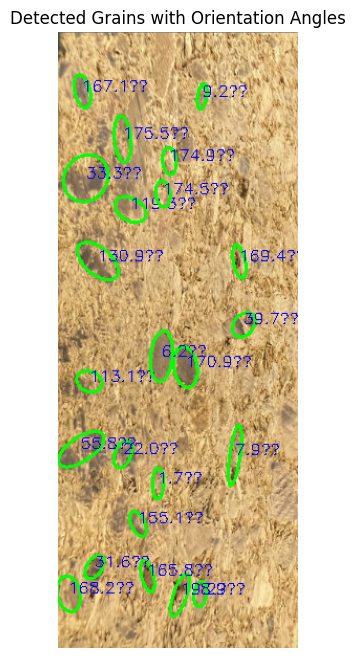

In [63]:
# =====================================
# Identify Grains using Image Processing
# =====================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img_path = "Sample\SampleBrick.png"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)  # improves contrast globally
blur = cv2.GaussianBlur(gray, (5, 5), 0)
# Adaptive thresh — make it more sensitive
thresh = cv2.adaptiveThreshold(
    blur, 300, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 15, 2)


# Step 3. Morphological operations to clean up small noise
kernel = np.ones((3,3), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 4. Find contours (each should correspond to a grain region)
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

grain_data = []
output = img.copy()

for i, cnt in enumerate(contours):
    if len(cnt) < 20:
        continue  # skip tiny regions
    (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
    grain_data.append({"center": (x, y), "angle": angle})
    
    # Draw ellipse and label
    cv2.ellipse(output, ((x, y), (MA, ma), angle), (0, 255, 0), 2)
    cv2.putText(output, f"{angle:.1f}°", (int(x), int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

print(f"Detected {len(grain_data)} grains")

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Detected Grains with Orientation Angles")
plt.axis('off')
plt.show()

In [52]:
def pca_orientation(contour):
    pts = contour.reshape(-1, 2).astype(np.float32)
    mean = pts.mean(axis=0)
    pts_centered = pts - mean
    cov = np.cov(pts_centered.T)
    eigvals, eigvecs = np.linalg.eig(cov)

    # principal axis = eigenvector with largest eigenvalue
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = np.degrees(np.arctan2(principal[1], principal[0]))
    angle = (angle + 360) % 180   # keep in [0,180)
    return angle, mean


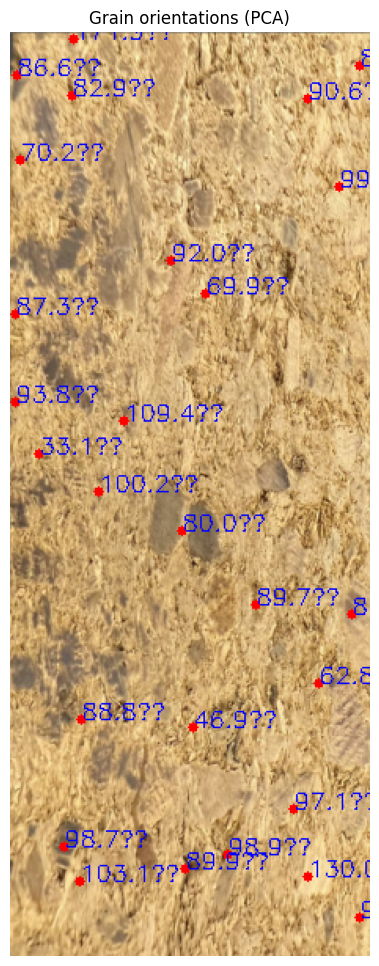

Detected grains: 27
Median orientation: 89.91160330543158


In [53]:
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = img.copy()
angles = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 80:   # do not remove larger grains
        continue

    angle, center = pca_orientation(cnt)
    angles.append(angle)

    cx, cy = int(center[0]), int(center[1])

    cv2.circle(output, (cx, cy), 3, (0,0,255), -1)
    cv2.putText(output, f"{angle:.1f}°", (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.figure(figsize=(6,12))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grain orientations (PCA)")
plt.show()

print("Detected grains:", len(angles))
print("Median orientation:", np.median(angles))
